Obtain clusters for information bottleneck analysis based on density in tsne space
- first run TsneForInfoBottleneck02.py in separate script to generate tsne map

In [78]:
#general stuff
import os
import h5py
import numpy as np
#for plotting
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
from scipy.spatial import KDTree
from scipy import ndimage as ndi
import matplotlib.cm as cm
#for finding the local maxima
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage as ndi
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
#for sorting the transition matrix
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import leaves_list
#set path to main folder
path2mainfolder='/Users/admin/Documents/AmsterdamResearch/InformationBottleneck/'

In [79]:
#Load tsne result
perplexity=60
results=h5py.File(path2mainfolder+'TsneResults/Perp'+str(perplexity)+'.h5','r')
spaces=np.array(results['space'])
entrynumber=np.array(results['entrynumber'])
results.close()

In [80]:
#Save data to h5 file with checking whether it exists
def save_save(h5fileobject,filename,dataset):
    test_file_exist='/'+filename in h5fileobject
    if test_file_exist:
        print('Output file already exists.')
        user_input = input('Do you want to replace file (y/n): ')
        if user_input=='y':
            del h5fileobject[filename]
            inputf = h5fileobject.create_dataset(filename,(dataset.shape))
            inputf[...]=dataset
    else:
        inputf = h5fileobject.create_dataset(filename,(dataset.shape))
        inputf[...]=dataset

In [81]:
#Density plot function
def density_plot(X,Y,xrange,yrange,n_grid_x,n_grid_y,border=5,smooth=False,log=False):
    '''
    Plots 2d density plot from X and Y
    xrange and yrange define the range of values on which to compute the density
    n_grid_x and n_grid_y are the number of grid divisions in the x and y axis respectively
    border defines a border around the data for the density estimation and smoothing
    if smooth=True, it will convolve a gaussian of the size of the border
    if log=True, it will get the log distributions (this is useful when the distinction of a certain peak is not easy)
    '''
    # view area range
    view_xmin,view_xmax=xrange
    view_ymin,view_ymax=yrange

    # get data
    xl = X
    yl = Y

    # get visible data points
    xlvis = []
    ylvis = []
    for i in range(0,len(xl)):
        if view_xmin < xl[i] < view_xmax and view_ymin < yl[i] < view_ymax:
            xlvis.append(xl[i])
            ylvis.append(yl[i])
    
    kx = (n_grid_x - 1) / (view_xmax - view_xmin)
    ky = (n_grid_y - 1) / (view_ymax - view_ymin)
    imgw = (n_grid_x + 2 * border)
    imgh = (n_grid_y + 2 * border)
    img = np.zeros((imgh,imgw))
    for x, y in zip(xl,yl):
        ix = int((x - view_xmin) * kx) + border
        iy = int((y - view_ymin) * ky) + border
        if 0 <= ix < imgw and 0 <= iy < imgh:
            img[iy][ix] += 1
    if smooth:
        if log:
            log_img=np.log10(img)
            sel=~np.isfinite(log_img)
            log_img[sel]=0.
            filtered_img=ndi.gaussian_filter(log_img, (border,border))
            return filtered_img
        else:
            return ndi.gaussian_filter(img, (border,border))  ## gaussian convolution
    else:
        if log:
            return np.log10(img)
        else:
            return img

In [82]:
#Generate density matrix
xrange=[spaces[:,0].min(),spaces[:,0].max()]
yrange=[spaces[:,1].min(),spaces[:,1].max()]
n_grid_x=256
n_grid_y=256
r=3
zd = density_plot(spaces[:,0],spaces[:,1],xrange,yrange,n_grid_x,n_grid_y,border=r,smooth=True)
#only for testing purposes:
#zd = density_plot([spaces[:,0].min(),0,spaces[:,0].max()],
#                  [spaces[spaces[:,0].argmin(),1],0,spaces[spaces[:,0].argmax(),1]],
#                  xrange,yrange,n_grid_x,n_grid_y,border=r,smooth=True)
#note: originally zd was of size n_grid_x+r x n_grid_y+r, which cause a lot of confusion
zd=zd[r:n_grid_y+r,r:n_grid_x+r];

In [83]:
#Find the peaks
#defines the coordinate space of the density plot (for the peak finding routine)
#x_flat = np.linspace(xrange[0],xrange[1],n_grid_x+2*r) #wrong
#y_flat = np.linspace(yrange[0],yrange[1],n_grid_y+2*r) #wrong
x_flat = np.linspace(xrange[0],xrange[1],n_grid_x) 
y_flat = np.linspace(yrange[0],yrange[1],n_grid_y)
x,y = np.meshgrid(x_flat,y_flat)

#peak_local_max finds the peaks in density. One can pick the minimum density for a peak
#to be considered a peak or, as I'm doing here, pick a threshold for the relative 
#size of a peak compared to the neighborhood
coordinates = peak_local_max(zd,threshold_rel=0.1)

#find the coordinates of the peaks
cx=[]
cy=[]
for i in range(len(coordinates)):
    a=coordinates[i,0]
    b=coordinates[i,1]
    cx.append(x[a,b])
    cy.append(y[a,b])
print('Number of peaks: '+str(len(cx)))

Number of peaks: 142


In [95]:
#Plot figure with peaks
plt.figure(figsize=(10,8))
plt.title('tsne Distribution',fontsize=20)
plt.imshow(zd , origin='lower', extent=[xrange[0], xrange[1], yrange[0], yrange[1]],cmap=cm.jet)
plt.colorbar()
cmap = cm.get_cmap('jet')
colors=cmap(np.linspace(0.01,1,len(cx)))
for i in range(len(cx)):
    #plt.scatter(cx[i],cy[i],s=100,c=colors[i])
    plt.scatter(cx[i],cy[i],s=100,c='k')
plt.grid(False)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel('$z_1$',fontsize=20)
plt.ylabel('$z_2$',fontsize=20)
#plt.savefig(path2mainfolder+'TsneResults/Perp'+str(perplexity)+'/TsnePeaks_Perp'+str(perplexity)+'.png')
#plt.show()

In [99]:
#Watershed algorithm around the local maxima
local_maxi = peak_local_max(zd,indices=False,threshold_rel=0.1) #false makes matrix with boolean TRUE at peak position
markers = ndi.label(local_maxi)[0] #gives labels to regions with TRUEs (is still a matrix with zero otherwise)
labels = watershed(-zd, markers)#, mask=zd)
numberofclusters=markers.max().max()
plt.figure(figsize=(10,8))
plt.imshow(labels, cmap=plt.cm.spectral,origin='lower',interpolation='nearest',
           extent=[xrange[0], xrange[1], yrange[0], yrange[1]])
for i in range(len(cx)):
    plt.scatter(cx[i],cy[i],s=100,c='k')
#plt.savefig(path2mainfolder+'TsneResults/Perp'+str(perplexity)+'/Watershed_Perp'+str(perplexity)+'.png')
#plt.show()

In [100]:
#Associate clusterid with points
#Get rounded position of points and look up cluster number in labeled matrix
view_xmin,view_xmax=xrange
view_ymin,view_ymax=yrange
kx = (n_grid_x - 1) / (view_xmax - view_xmin)
ky = (n_grid_y - 1) / (view_ymax - view_ymin)
clusterid=np.empty(len(spaces[:,0])) * np.nan
clusterseedid=np.empty((len(cx),2)) * np.nan
for i in range(len(spaces[:,0])):
    #ix = int((spaces[i,0] - view_xmin) * kx + r) #wrong
    #iy = int((spaces[i,1] - view_ymin) * ky + r) #wrong
    ix = int((spaces[i,0] - view_xmin) * kx)
    iy = int((spaces[i,1] - view_ymin) * ky)
    clusterid[i] = labels[iy,ix]
#Check whether label of watershed cluster is identical to original cluster number
#note that labels range (1,N) while old cluster number range (0,N-1)
for i in range(len(cx)):
    ix = int((cx[i] - view_xmin) * kx)
    iy = int((cy[i] - view_ymin) * ky)
    #first column with new cluster label, second column shows old cluster number at new label position
    if (labels[iy,ix]-1) != i:
        print('Clusters are not identical in '+str(i))

In [107]:
#Print result
unique_labels = set(clusterid)
colors = plt.cm.Spectral(np.linspace(0, 1,len(unique_labels)))
np.random.shuffle(colors)
plt.figure(figsize=(12,10))
for k, col in zip(unique_labels, colors):
    class_member_mask = (clusterid == k)
    xy = spaces[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=col,s=10)
entrynumbercs=np.cumsum(entrynumber).astype(int)
entrynumberst=np.append(0,entrynumbercs[:-1]).astype(int)
trach=300 #trace choice
plt.scatter(spaces[entrynumberst[trach], 0],spaces[entrynumberst[trach], 1],color='k',s=30)
plt.plot(spaces[entrynumberst[trach]:entrynumbercs[trach], 0],
         spaces[entrynumberst[trach]:entrynumbercs[trach], 1],'k')
#plt.savefig(path2mainfolder+'TsneResults/Perp'+str(perplexity)+'/WScluster_Tr'+str(trach)+'_Perp'+str(perplexity)+'.png')
#plt.show()

In [108]:
#Plot several traces
figh, axarr = plt.subplots(2, 3 ,figsize=(12,8))
for trach in np.array([60,61,62]):
    for k, col in zip(unique_labels, colors):
        class_member_mask = (clusterid == k)
        xy = spaces[class_member_mask]
        axarr[0,trach-60].scatter(xy[:, 0], xy[:, 1], c=col,s=10)
    entrynumbercs=np.cumsum(entrynumber).astype(int)
    entrynumberst=np.append(0,entrynumbercs[:-1]).astype(int)
    axarr[0,trach-60].scatter(spaces[entrynumberst[trach], 0],spaces[entrynumberst[trach], 1],color='k',s=30)
    axarr[0,trach-60].plot(spaces[entrynumberst[trach]:entrynumbercs[trach], 0],
             spaces[entrynumberst[trach]:entrynumbercs[trach], 1],'k')
for trach in np.array([63,64,65]):
    for k, col in zip(unique_labels, colors):
        class_member_mask = (clusterid == k)
        xy = spaces[class_member_mask]
        axarr[1,trach-63].scatter(xy[:, 0], xy[:, 1], c=col,s=10)
    entrynumbercs=np.cumsum(entrynumber).astype(int)
    entrynumberst=np.append(0,entrynumbercs[:-1]).astype(int)
    axarr[1,trach-63].scatter(spaces[entrynumberst[trach], 0],spaces[entrynumberst[trach], 1],color='k',s=30)
    axarr[1,trach-63].plot(spaces[entrynumberst[trach]:entrynumbercs[trach], 0],
             spaces[entrynumberst[trach]:entrynumbercs[trach], 1],'k')
#plt.savefig(path2mainfolder+'TsneResults/Perp'+str(perplexity)+'/ExTr60to65_Perp'+str(perplexity)+'.png')
#plt.show()

In [111]:
#Similar plot with points and watershed regions for inspection
plt.figure(figsize=(20,18))
plt.imshow(labels, cmap=plt.cm.spectral,origin='lower',interpolation='nearest',
           extent=[xrange[0], xrange[1], yrange[0], yrange[1]])
for k, col in zip(unique_labels, colors):
    class_member_mask = (clusterid == k)
    xy = spaces[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=col,s=10)
for i in range(len(cx)):
    plt.scatter(cx[i],cy[i],s=100,c='k')
#plt.show()

In [114]:
#Plot like above with points and watershed regions, now just outlines
plt.figure(figsize=(20,18))
plt.imshow(abs(labels[:-1,:-1]-labels[1:,1:])>0,origin='lower',interpolation='nearest',
           extent=[xrange[0], xrange[1], yrange[0], yrange[1]])
for k, col in zip(unique_labels, colors):
    class_member_mask = (clusterid == k)
    xy = spaces[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=col,s=10)
for i in range(len(cx)):
    plt.scatter(cx[i],cy[i],s=100,c='r')
#plt.show()

In [115]:
#Save clustering result
f=h5py.File(path2mainfolder+'TsneResults/Perp'+str(perplexity)+'.h5','a')
save_save(f,'clusterid',clusterid)
save_save(f,'numberofclusters',numberofclusters)
f.close()

Output file already exists.
Do you want to replace file (y/n): y
Output file already exists.
Do you want to replace file (y/n): y


In [116]:
#Compute transition matrix
followupindex=np.c_[clusterid[:-1],clusterid[1:]]
f=h5py.File(path2mainfolder+'TsneResults/Perp'+str(perplexity)+'.h5','r')
entrynumber=np.array(f['entrynumber'])
f.close()
deletionvector=np.cumsum(entrynumber)-1
followupindexdel=np.delete(followupindex,deletionvector,0).astype(int) #cast to int
transitionmatrix=np.zeros((numberofclusters,numberofclusters))
for i in range(len(followupindexdel)):
    transitionmatrix[followupindexdel[i,0]-1,followupindexdel[i,1]-1] += 1.0

In [117]:
#Save transition matrix
f=h5py.File(path2mainfolder+'TsneResults/Perp'+str(perplexity)+'.h5','a')
save_save(f,'transmat',transitionmatrix)
f.close()

Output file already exists.
Do you want to replace file (y/n): y


In [121]:
#Only look at the most likely transition from each cluster
mostlikelytrans=np.argmax(transitionmatrix,axis=1)
plt.figure(figsize=(10,8))
for i in range(len(cx)):
    plt.scatter(cx[i],cy[i],s=100,c='k')
    if transitionmatrix[i,mostlikelytrans[i]]>5:
    #if transitionmatrix[i,mostlikelytrans[i]]/np.sum(clusterid == i+1)>0.08:
        if i==mostlikelytrans[i]:
            plt.plot(cx[i],cy[i],'ro')
            plt.text(cx[i],cy[i], str(i+1), fontsize=12)
        else:
            plt.arrow(cx[i],cy[i],cx[mostlikelytrans[i]]-cx[i],cy[mostlikelytrans[i]]-cy[i],color='r',
                     length_includes_head=True,head_width=2)
            #plt.plot([cx[i],cx[mostlikelytrans[i]]],[cy[i],cy[mostlikelytrans[i]]],'r',
            #         linewidth=int(transitionmatrix[i,mostlikelytrans[i]]/5))
            plt.text(cx[i],cy[i], str(i+1), fontsize=12)
            plt.text(cx[mostlikelytrans[i]],cy[mostlikelytrans[i]],
                     str(mostlikelytrans[i]+1), fontsize=12)
#plt.savefig(path2mainfolder+'TsneResults/Perp'+str(perplexity)+'/MostTransL5_Perp'+str(perplexity)+'.png')
#plt.show()

In [124]:
#Transitions between clusters - line width indicates number
figh, axarr = plt.subplots(1, 3 ,figsize=(18,6))
kind=0;
for k in np.array([10,15,20]):
    for i in range(len(cx)):
        axarr[kind].scatter(cx[i],cy[i],s=100,c='k')
        for j in range(len(cy)):
            if transitionmatrix[i,j]>k:
                if i==j:
                    axarr[kind].plot(cx[i],cy[i],'ro')
                    axarr[kind].text(cx[i],cy[i], str(i+1), fontsize=12)
                else:
                    axarr[kind].plot([cx[i],cx[j]],[cy[i],cy[j]],'r',linewidth=int(transitionmatrix[i,j]/5))
                    axarr[kind].text(cx[i],cy[i], str(i+1), fontsize=12)
                    axarr[kind].text(cx[j],cy[j],str(j+1), fontsize=12)
    axarr[kind].set_title('> '+str(k)+' Transitions')
    kind = kind+1
#plt.savefig(path2mainfolder+'TsneResults/Perp'+str(perplexity)+'/Transitions_Perp'+str(perplexity)+'.png') #.eps
#plt.show()

In [127]:
#Only one treshold for the transion, line width in either absolute or relative terms
plt.figure(figsize=(10,8))
for i in range(len(cx)):
    plt.scatter(cx[i],cy[i],s=100,c='k')
    for j in range(len(cy)):
        if transitionmatrix[i,j]>10:
            if i==j:
                plt.plot(cx[i],cy[i],'ro')
                plt.text(cx[i],cy[i], str(i+1), fontsize=12)
            else:
                #plt.plot([cx[i],cx[j]],[cy[i],cy[j]],'r',linewidth=int(transitionmatrix[i,j]/5))
                plt.plot([cx[i],cx[j]],[cy[i],cy[j]],'r',
                         linewidth=int(transitionmatrix[i,j]/np.sum(clusterid == i+1)*30))
                plt.text(cx[i],cy[i], str(i+1), fontsize=12)
                plt.text(cx[j],cy[j],str(j+1), fontsize=12)
#plt.show()

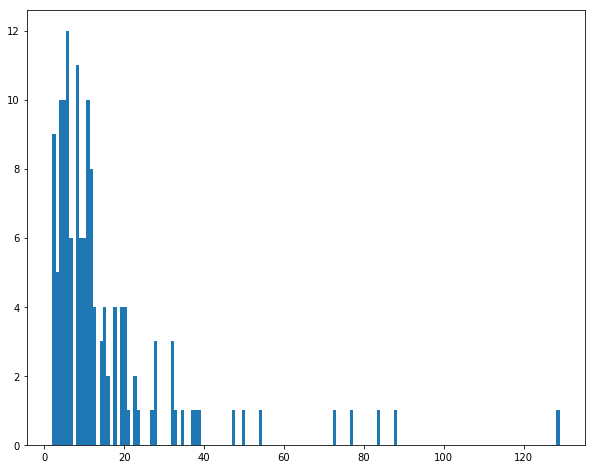

In [154]:
#Distribution of transitions from each clusters
maxtransitions=np.amax(transitionmatrix, axis=1)
plt.figure(figsize=(10,8))
plt.hist(maxtransitions, bins=150)
plt.show()

In [254]:
#Transition matrix either in log or normal scale or only in a certain range (don't forget to change colorbar label)
transitionmatrixdistance = pdist(transitionmatrix, 'euclidean')
linkagematrix = linkage(transitionmatrixdistance, 'ward')
clusterorder=leaves_list(linkagematrix)
transitionmatrixordtemp=np.copy(transitionmatrix)
for i in range(len(clusterorder)):
    transitionmatrixordtemp[i,:]=transitionmatrix[clusterorder[i],:]
transitionmatrixord=np.copy(transitionmatrix)
for i in range(len(clusterorder)):
    transitionmatrixord[:,i]=transitionmatrixordtemp[:,clusterorder[i]]
plt.figure(figsize=(10,8))
plt.title('Transition Matrix',fontsize=20)
#plt.imshow(np.log10(transitionmatrixord), origin='lower',cmap=cm.jet)
transitionmatrixord[(transitionmatrixord>20)]=20
plt.imshow(transitionmatrixord, origin='lower',cmap=cm.jet)
cbar = plt.colorbar()
cbar.set_ticks(np.linspace(0, 20, 5))
cbar.ax.set_yticklabels(['0','5','10','15','>20'])
plt.grid(False)
plt.xlabel('$to$',fontsize=20)
plt.ylabel('$from$',fontsize=20)
#plt.savefig(path2mainfolder+'TsneResults/Perp'+str(perplexity)+'/TransMatS20_Perp'+str(perplexity)+'.png')
#plt.show()

In [55]:
#Read hierarchical cluster from MATLAB (not really needed anymore as the result above already looks nice)
f=h5py.File(r'TsneResults/Perp'+str(perplexity)+'.h5','r')
hierarchsort=(np.array(f['hierarchsort'])-1).astype(int)
hierarchsort=np.transpose(hierarchsort)[0] #DELETE maybe later when changing matlab saving procedure
f.close()
transitionmatrixordtemp=np.copy(transitionmatrix)
for i in range(len(hierarchsort)):
    transitionmatrixordtemp[i,:]=transitionmatrix[hierarchsort[i],:]
transitionmatrixord=np.copy(transitionmatrix)
for i in range(len(hierarchsort)):
    transitionmatrixord[:,i]=transitionmatrixordtemp[:,hierarchsort[i]]
plt.figure(figsize=(10,8))
plt.title('Transition Matrix',fontsize=20)
plt.imshow(np.log10(transitionmatrixord), origin='lower',cmap=cm.jet)
#plt.imshow(transitionmatrixord, origin='lower',cmap=cm.jet)
plt.colorbar()
plt.grid(False)
plt.xlabel('$to$',fontsize=20)
plt.ylabel('$from$',fontsize=20)
#plt.savefig(r'TsneResults/transmatsortPerp'+str(perplexity)+'.eps')
plt.show()

"f=h5py.File(r'TsneResults/Perp'+str(perplexity)+'.h5','r')\nhierarchsort=(np.array(f['hierarchsort'])-1).astype(int)\nhierarchsort=np.transpose(hierarchsort)[0] #DELETE maybe later when changing matlab saving procedure\nf.close()\ntransitionmatrixordtemp=transitionmatrix\nfor i in range(len(hierarchsort)):\n    transitionmatrixordtemp[i,:]=transitionmatrix[hierarchsort[i],:]\ntransitionmatrixord=transitionmatrix\nfor i in range(len(hierarchsort)):\n    transitionmatrixord[:,i]=transitionmatrixordtemp[:,hierarchsort[i]]\nplt.figure(figsize=(10,8))\nplt.title('Transition Matrix',fontsize=20)\nplt.imshow(np.log10(transitionmatrixord), origin='lower',cmap=cm.jet)\n#plt.imshow(transitionmatrixord, origin='lower',cmap=cm.jet)\nplt.colorbar()\nplt.grid(False)\nplt.xlabel('$to$',fontsize=20)\nplt.ylabel('$from$',fontsize=20)\n#plt.savefig(r'TsneResults/transmatsortPerp'+str(perplexity)+'.eps')\nplt.show()"

Does not work:
from polo import optimal_leaf_ordering
optimal_Z = optimal_leaf_ordering(linkagematrix, transitionmatrixdistance)
optimal_Z.shape

In [214]:
#K-means clustering of the tsne space
clusternumber=150;
clusteredspaces = KMeans(n_clusters=clusternumber).fit_predict(spaces)
cmap = cm.get_cmap('jet')
colors=cmap(np.linspace(0.01,1,clusternumber))
plt.figure(figsize=(10,8))
plt.scatter(spaces[:, 0], spaces[:, 1], c=colors[clusteredspaces])
#plt.show()

In [215]:
#K-means clustering of the original thetas then plotted in tsne space
results=h5py.File(path2mainfolder+'TsneResults/Perp'+str(perplexity)+'.h5','r')
allthetas=np.array(results['allthetas'])
results.close()
clusternumber=150;
clusteredthetas = KMeans(n_clusters=clusternumber).fit_predict(allthetas)
cmap = cm.get_cmap('jet')
colors=cmap(np.linspace(0.01,1,clusternumber))
plt.figure(figsize=(10,8))
plt.scatter(spaces[:, 0], spaces[:, 1], c=colors[clusteredthetas])
#plt.show()

In [228]:
clustermean=np.ones((clusternumber,allthetas.shape[1]))
icount=0
for i in range(clusternumber):
    myselection=(clusteredthetas==i)
    if np.sum(myselection)>10:
        clustermean[icount]=np.sum(allthetas[myselection,:],axis=0)
        clusteredthetas[myselection]=icount
        icount=icount+1
    else:
        clusteredthetas[myselection]=clusternumber
clustermean=clustermean[:icount,:]
for i in range(len(clusteredthetas)):
    if clusteredthetas[i]==clusternumber:
        tempdist=np.ones(icount)
        for j in range(icount):
            tempdist[j]=np.sum((allthetas[i,:]-clustermean[j,:])**2)
        clusteredthetas[i]=np.argmin(tempdist)
clusternumber=icount

In [231]:
cmap = cm.get_cmap('jet')
colors=cmap(np.linspace(0.01,1,clusternumber))
plt.figure(figsize=(10,8))
plt.scatter(spaces[:, 0], spaces[:, 1], c=colors[clusteredthetas])
#plt.savefig(path2mainfolder+'TsneResults/Perp'+str(perplexity)+'/ClustThetas_Perp'+str(perplexity)+'.png')
#plt.show()

In [217]:
#Compute transition matrix
followupindex=np.c_[clusteredthetas[:-1],clusteredthetas[1:]]
deletionvector=np.cumsum(entrynumber)-1
followupindexdel=np.delete(followupindex,deletionvector,0).astype(int) #cast to int
transitionmatrixthetas=np.zeros((clusternumber,clusternumber))
for i in range(len(followupindexdel)):
    transitionmatrixthetas[followupindexdel[i,0]-1,followupindexdel[i,1]-1] += 1.0

In [218]:
#Save transition matrix
f=h5py.File(path2mainfolder+'TsneResults/Perp'+str(perplexity)+'.h5','a')
save_save(f,'transmatthetas',transitionmatrixthetas)
f.close()

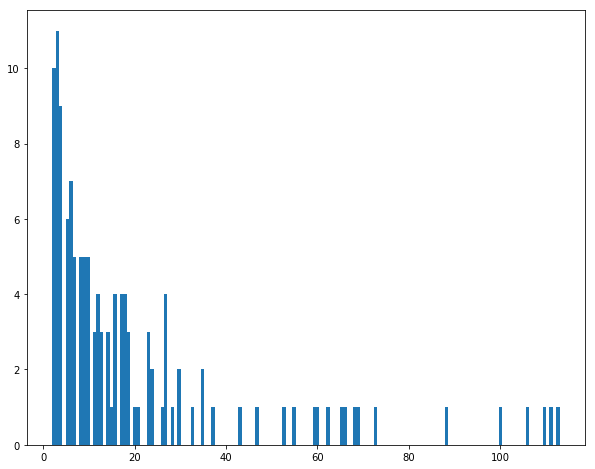

In [260]:
#Distribution of transitions from each clusters
maxtransitions=np.amax(transitionmatrixthetas, axis=1)
plt.figure(figsize=(10,8))
plt.hist(maxtransitions, bins=150)
plt.show()

In [258]:
#Transition matrix either in log or normal scale or only in a certain range (don't forget to change colorbar label)
transitionmatrixdistance = pdist(transitionmatrixthetas, 'euclidean')
linkagematrix = linkage(transitionmatrixdistance, 'ward')
clusterorder=leaves_list(linkagematrix)
transitionmatrixordtemp=np.copy(transitionmatrixthetas)
for i in range(len(clusterorder)):
    transitionmatrixordtemp[i,:]=transitionmatrixthetas[clusterorder[i],:]
transitionmatrixord=np.copy(transitionmatrixthetas)
for i in range(len(clusterorder)):
    transitionmatrixord[:,i]=transitionmatrixordtemp[:,clusterorder[i]]
plt.figure(figsize=(10,8))
plt.title('Transition Matrix',fontsize=20)
#plt.imshow(np.log10(transitionmatrixord), origin='lower',cmap=cm.jet)
transitionmatrixord[(transitionmatrixord>20)]=20
plt.imshow(transitionmatrixord, origin='lower',cmap=cm.jet)
cbar = plt.colorbar()
#cbar.ax.set_yticklabels(['0','5','10','15','20','25','>30'])
cbar.set_ticks(np.linspace(0, 20, 5))
cbar.ax.set_yticklabels(['0','5','10','15','>20'])
plt.grid(False)
plt.xlabel('$to$',fontsize=20)
plt.ylabel('$from$',fontsize=20)
#plt.savefig(path2mainfolder+'TsneResults/Perp'+str(perplexity)+'/TransMatThetasS20_Perp'+str(perplexity)+'.png')
#plt.show()

In [159]:
#DBscan clustering (doesn't seem to work so well)
db = DBSCAN(eps=0.7, min_samples=5).fit(spaces)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

#print('Estimated number of clusters: %d' % n_clusters_)

# Black removed and is used for noise instead.
plt.figure(figsize=(10,8))
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = spaces[class_member_mask & core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=col)
    #plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
         #    markeredgecolor='k', markersize=14)

    xy = spaces[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=col)
    #plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
      #       markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
#plt.show()